In [1]:
import pickle
with open("1_harmonized_LUCAS.pkl", "rb") as f:
    df = pickle.load(f)

Scale Cmic to unit of SOC

In [2]:
df['Cmic_2018'] = df['Cmic_2018'] /1000

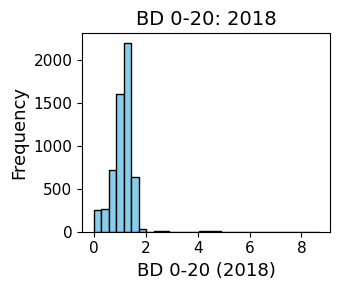

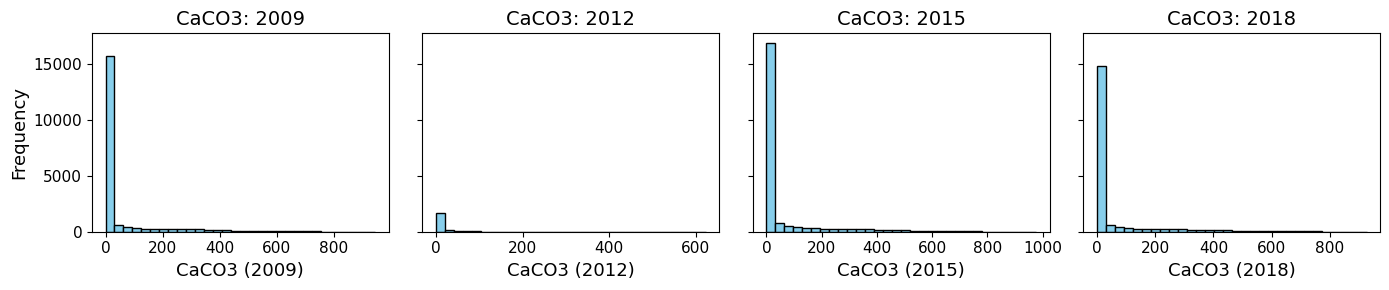

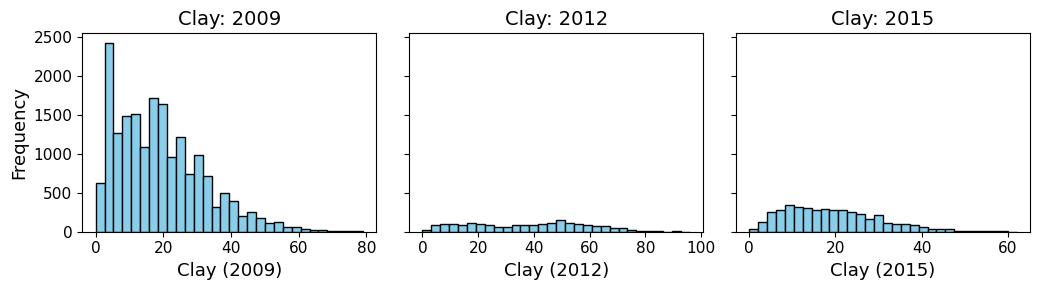

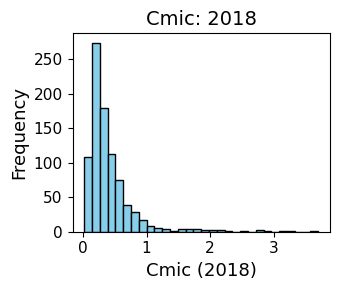

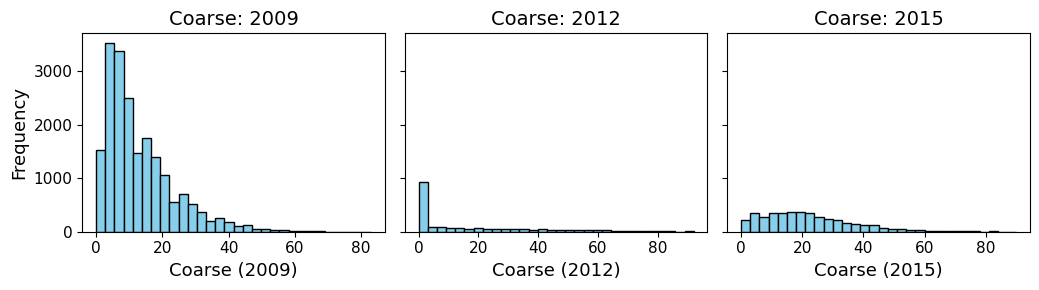

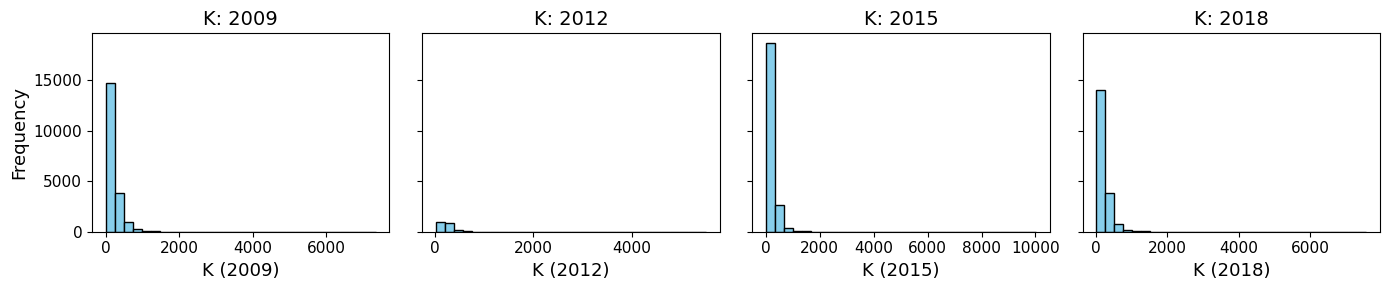

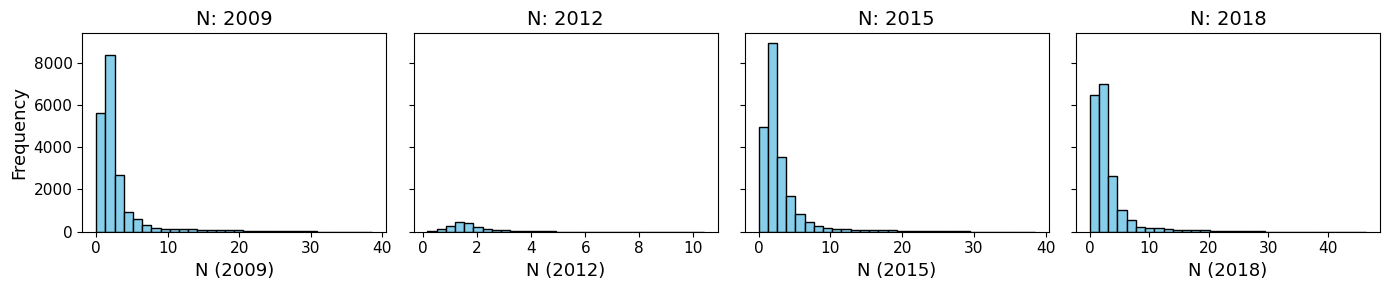

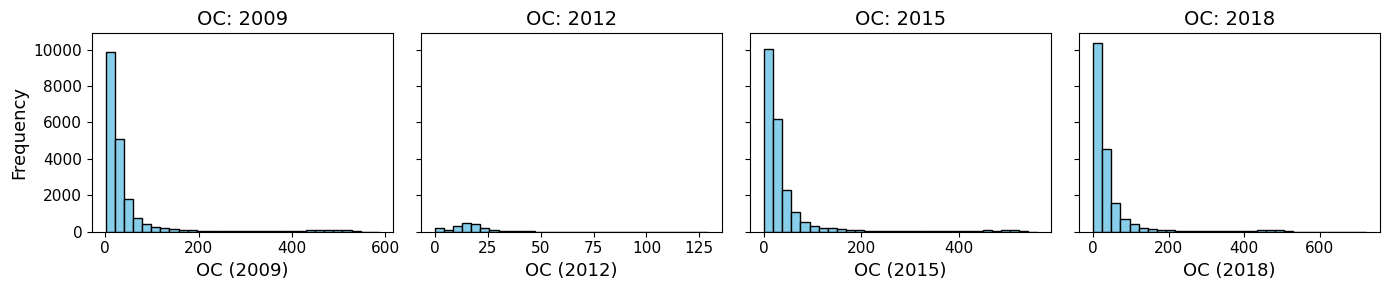

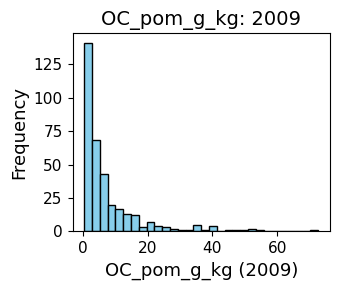

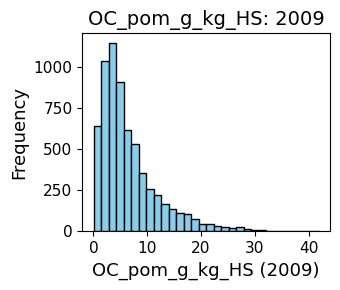

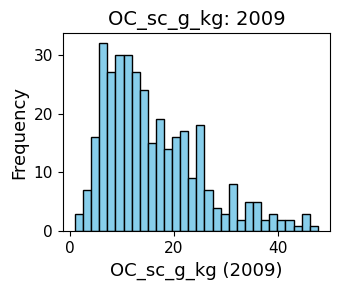

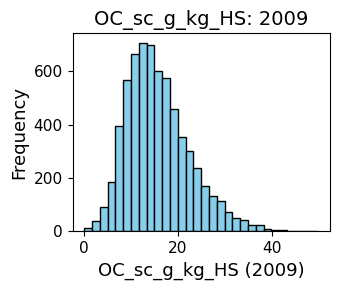

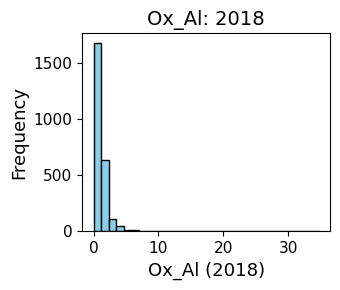

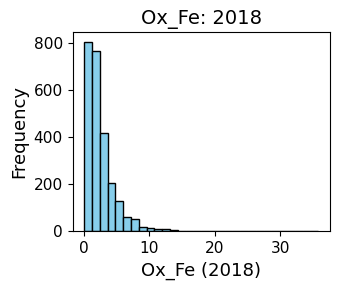

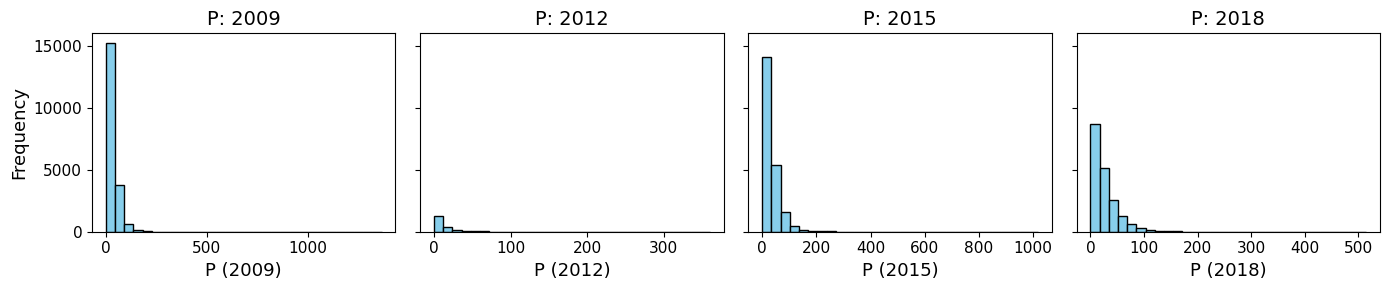

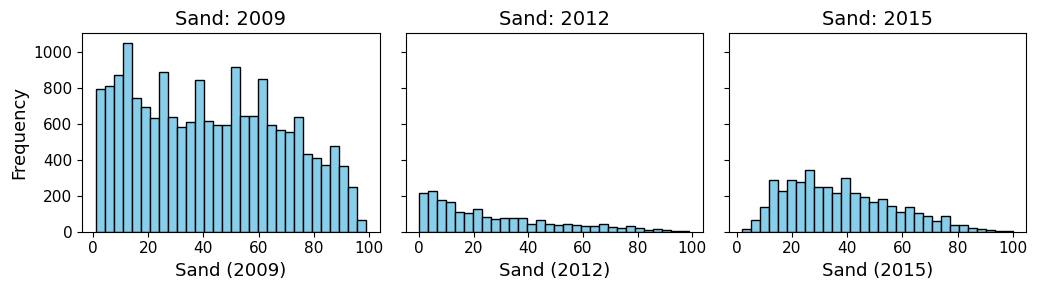

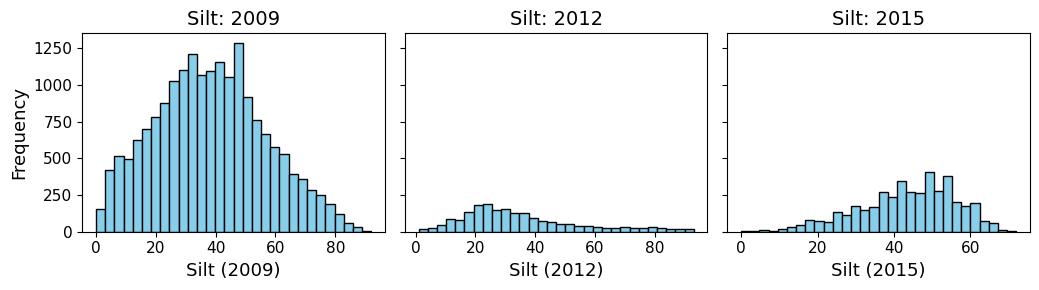

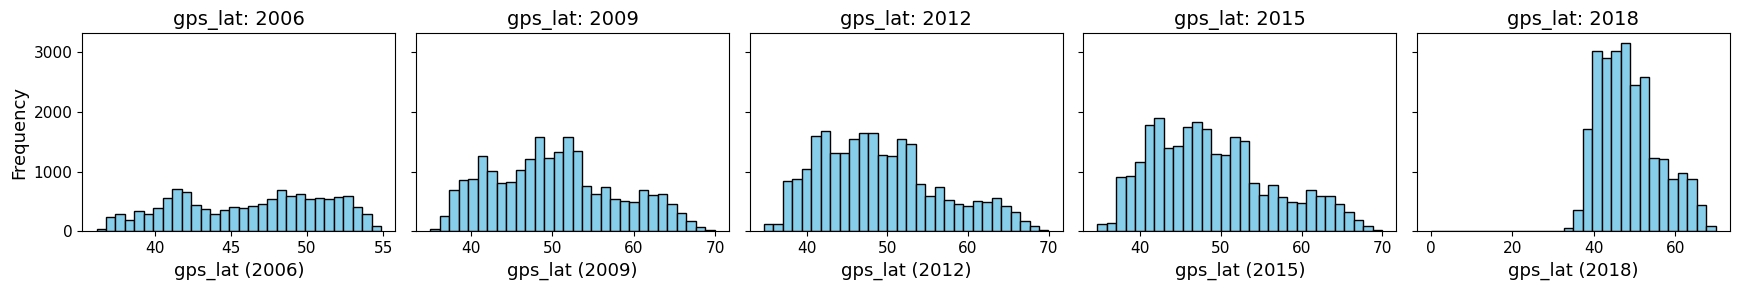

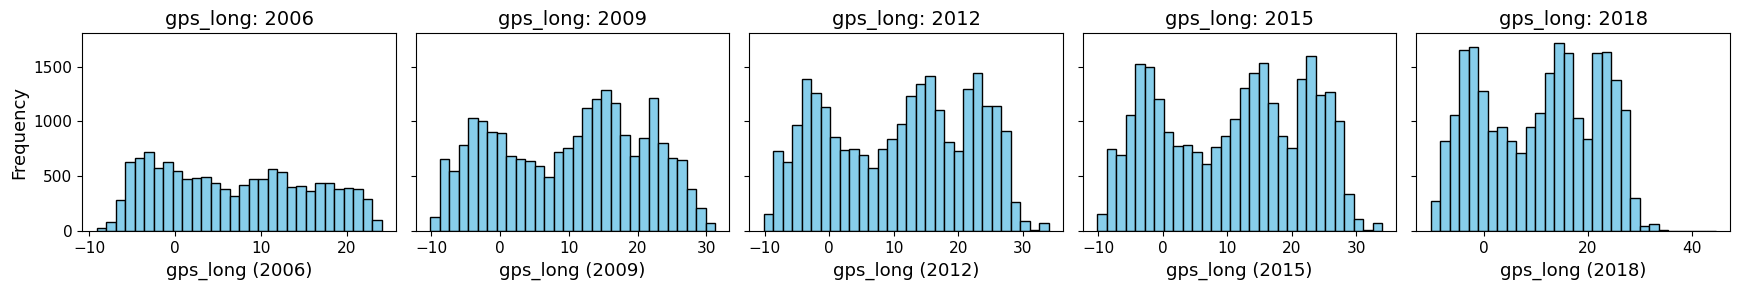

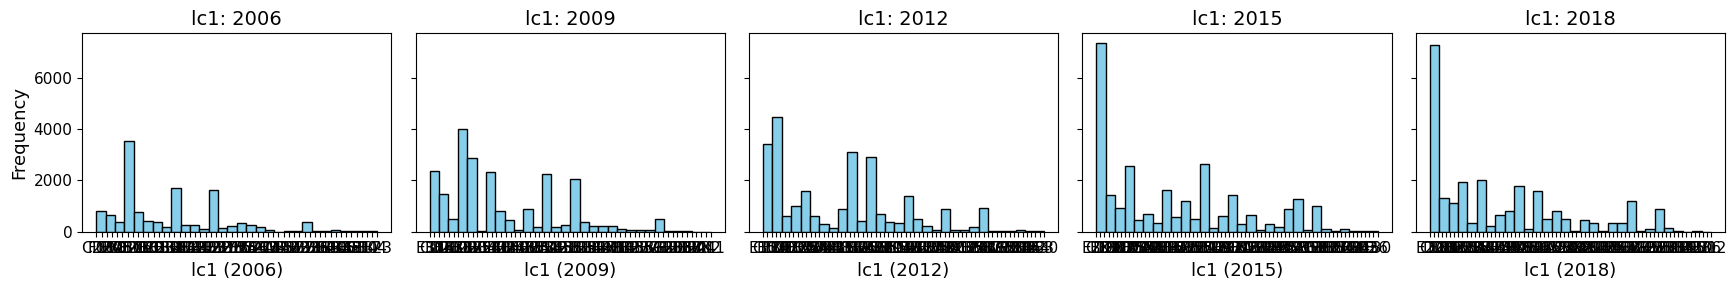

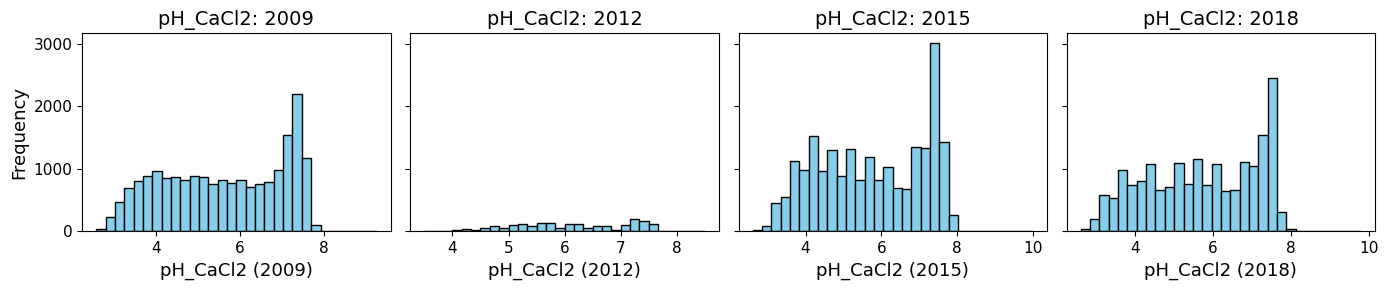

In [3]:
import matplotlib.pyplot as plt
import re
import pandas as pd

# Use regex to find column names like 'var_YYYY'
pattern = re.compile(r'^(.*)_(\d{4})$')

variable_year_pairs = []
for col in df.columns:
    match = pattern.match(col)
    if match:
        variable, year = match.group(1), match.group(2)
        variable_year_pairs.append((variable, year))

# Get unique variable names, then sort them
variables = sorted({var for var, yr in variable_year_pairs})
years = sorted({yr for var, yr in variable_year_pairs})

def get(variable, year):
    col = f"{variable}_{year}"
    if col in df.columns:
        return df[col]
    else:
        return pd.Series([None] * len(df))

def hist(variable, year):
    values = get(variable, year)
    filtered_values = values[values.notnull()]
    fig, ax = plt.subplots(figsize=(4, 3))
    ax.hist(filtered_values, bins=30, color='skyblue', edgecolor='black')
    ax.set_xlabel(f'{variable} ({year}, per unit SOC)', fontsize=14)
    ax.set_ylabel('Frequency', fontsize=14)
    ax.tick_params(axis='both', labelsize=12)
    plt.tight_layout()
    plt.show()
    return fig, ax

def hists(df, variable, show=True):
    # Dynamically find year-suffixed columns for this variable
    var_years = []
    for col in df.columns:
        match = pattern.match(col)
        if match:
            var, year = match.group(1), match.group(2)
            if var == variable:
                var_years.append(year)
    var_years = sorted(var_years)
    n_years = len(var_years)
    if n_years == 0:
        # No year-suffixed columns found. Try plotting the raw variable.
        if variable in df.columns:
            values = df[variable]
            filtered_values = values[values.notnull()]
            fig, ax = plt.subplots(figsize=(4, 3))
            ax.hist(filtered_values, bins=30, color='skyblue', edgecolor='black')
            ax.set_xlabel(f'{variable}', fontsize=14)
            ax.set_ylabel('Frequency', fontsize=14)
            ax.set_title(variable, fontsize=14)
            ax.tick_params(axis='both', labelsize=12)
            plt.tight_layout()
            if show:
                plt.show()
        else:
            print(f"Skipping {variable!r}: no year-suffixed columns or raw column found.")
        return
    fig, axes = plt.subplots(1, n_years, figsize=(3.5 * n_years, 3), sharey=True)
    if n_years == 1:
        axes = [axes]
    for i, year in enumerate(var_years):
        values = get(variable, year)
        filtered_values = values[values.notnull()]
        axes[i].hist(filtered_values, bins=30, color='skyblue', edgecolor='black')
        axes[i].set_xlabel(f'{variable} ({year})', fontsize=13)
        if i == 0:
            axes[i].set_ylabel('Frequency', fontsize=13)
        axes[i].set_title(f'{variable}: {year}', fontsize=14)
        axes[i].tick_params(axis='both', labelsize=11)
    plt.tight_layout()
    if show:
        plt.show()

# Example usage for all variables present with year:
for var in variables:
    hists(df, var)


Delete unrealistic values

In [4]:
bd_problematic_indices = [i for i, v in enumerate(df['BD 0-20_2018']) if v is not None and (v < 0.05 or v > 2.3)]
print([df['BD 0-20_2018'][i] for i in bd_problematic_indices])
if bd_problematic_indices:
    df.at[bd_problematic_indices[-1], 'BD 0-20_2018'] = None

[np.float64(2.715), np.float64(2.483), np.float64(2.816), np.float64(3.694), np.float64(5.812), np.float64(0.016), np.float64(6.62), np.float64(8.666), np.float64(6.077), np.float64(0.029), np.float64(2.669), np.float64(0.015), np.float64(5.433), np.float64(2.574), np.float64(0.018), np.float64(0.025), np.float64(5.873), np.float64(0.039), np.float64(0.032), np.float64(0.026), np.float64(0.031), np.float64(0.036), np.float64(0.013), np.float64(-0.018), np.float64(0.014), np.float64(0.027), np.float64(2.309), np.float64(0.003), np.float64(0.01), np.float64(0.044), np.float64(0.037), np.float64(0.049), np.float64(0.031), np.float64(0.023), np.float64(0.029), np.float64(0.023), np.float64(0.022), np.float64(0.026), np.float64(0.024), np.float64(5.56), np.float64(4.184), np.float64(4.272), np.float64(4.721), np.float64(4.983), np.float64(4.55), np.float64(4.674), np.float64(4.859), np.float64(4.475), np.float64(4.642), np.float64(4.245), np.float64(4.574), np.float64(4.702), np.float64(4.8

Set 0.0 to .5*detection limit, so the distributions are less distorted

In [5]:
import numpy as np

years = [2009, 2012, 2015, 2018]
replace_0 = ["Coarse", "Clay", "Silt", "Sand", "OC", "CaCO3", "N", "K", "P"]

for var in replace_0:
    # Identify which columns for this variable actually exist (for available years)
    cols = [f"{var}_{year}" for year in years if f"{var}_{year}" in df.columns]
    if not cols:
        continue

    min_val = np.inf
    # Find the minimum nonzero value across all existing year-columns for this variable
    for col in cols:
        values = df[col].dropna()
        nonzero_values = values[values != 0.0]
        if len(nonzero_values) > 0:
            year_min = nonzero_values.min()
            if year_min < min_val:
                min_val = year_min
    # Replace 0.0 with 0.5 * min_val for each existing year column
    for col in cols:
        mask = df[col] == 0.0
        df.loc[mask, col] = 0.5 * min_val

Summarize texture

In [6]:
def summarize_texture(df, var_substr):
    years = [2015, 2012, 2009]
    first_col = f"{var_substr}_{years[0]}"    
    output = df[first_col].copy()
    print(f"Non-NaN for {first_col}: {output.notna().sum()}")
    for year in years[1:]:
        col = f"{var_substr}_{year}"
        output = output.where(~output.isna(), df[col])
        print(f"Non-NaN for {col}: {output.notna().sum()}")
    df[var_substr] = output
    print()

summarize_texture(df, 'Clay')
summarize_texture(df, 'Silt')
summarize_texture(df, 'Sand')
summarize_texture(df, 'Coarse')

Non-NaN for Clay_2015: 4260
Non-NaN for Clay_2012: 6281
Non-NaN for Clay_2009: 25011

Non-NaN for Silt_2015: 4260
Non-NaN for Silt_2012: 6279
Non-NaN for Silt_2009: 25009

Non-NaN for Sand_2015: 4260
Non-NaN for Sand_2012: 6281
Non-NaN for Sand_2009: 25011

Non-NaN for Coarse_2015: 4258
Non-NaN for Coarse_2012: 6292
Non-NaN for Coarse_2009: 26150



calculate ratios: C:Nutrient, MAOC/Cmic indices

In [7]:
for year in [2009, 2012, 2015, 2018]:
    for nutrient in ['N', 'P', 'K']:
        df[f'C{nutrient}r_{year}'] = df[f'OC_{year}'] / df[f'{nutrient}_{year}']

df['MAOC_index_2009'] = df['OC_sc_g_kg_2009'] / (df['OC_sc_g_kg_2009']+df['OC_pom_g_kg_2009'])
df['Cmic_index_2018'] = df['Cmic_2018'] / df['OC_2018']


pH-CaCO3

Number of CaCO3_2009 > 5 vs <= 5: 5698 / 14162
First 10 values: [nan, 0.5, 7.0, 56.0, 2.0, 128.0, 0.5, 20.0, 2.0, 1.0]

First 10 values: [nan, False, True, True, False, True, False, True, False, False]
Number of CaCO3_2012 > 5 vs <= 5: 490 / 1536
First 10 values: [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]

First 10 values: [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
Number of CaCO3_2015 > 5 vs <= 5: 6420 / 15439
First 10 values: [nan, nan, nan, 34.0, 0.5, 46.0, 0.5, 0.5, nan, 0.5]

First 10 values: [nan, nan, nan, True, False, True, False, False, nan, False]
Number of CaCO3_2018 > 5 vs <= 5: 5383 / 13599
First 10 values: [190.0, nan, nan, 204.0, 0.5, 10.0, 0.5, 10.0, nan, nan]

First 10 values: [True, nan, nan, True, False, True, False, True, nan, nan]


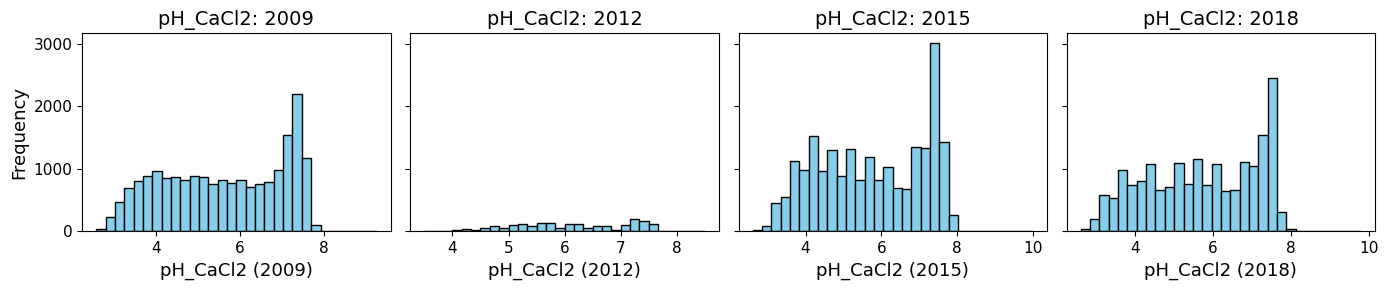

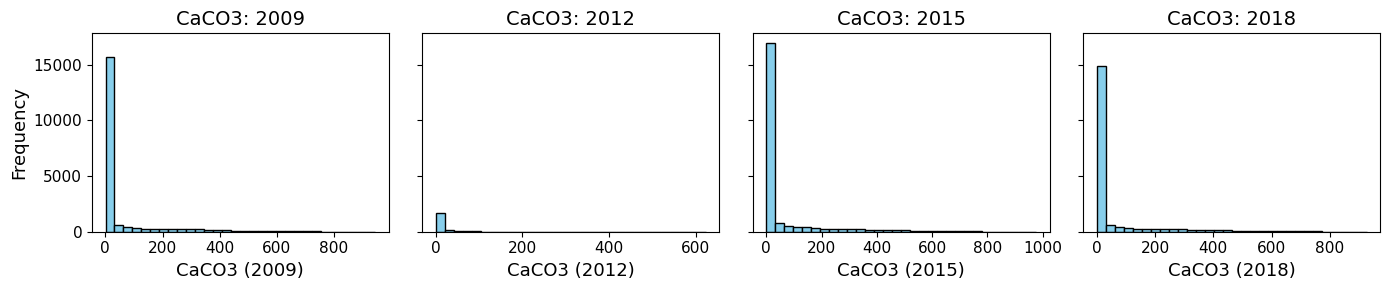

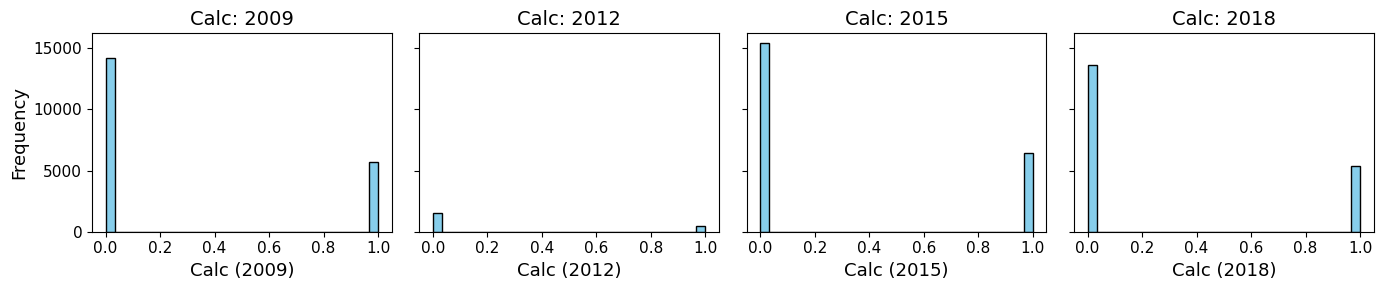

Skipping 'CaCO3_c_log': no year-suffixed columns or raw column found.


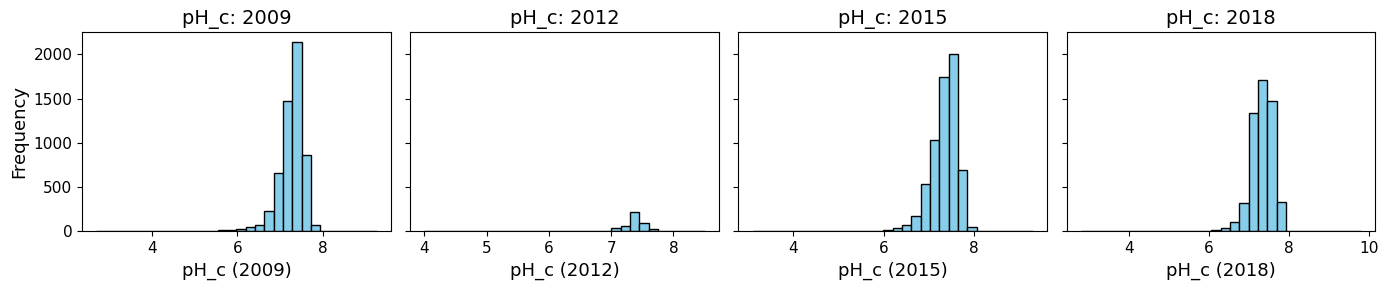

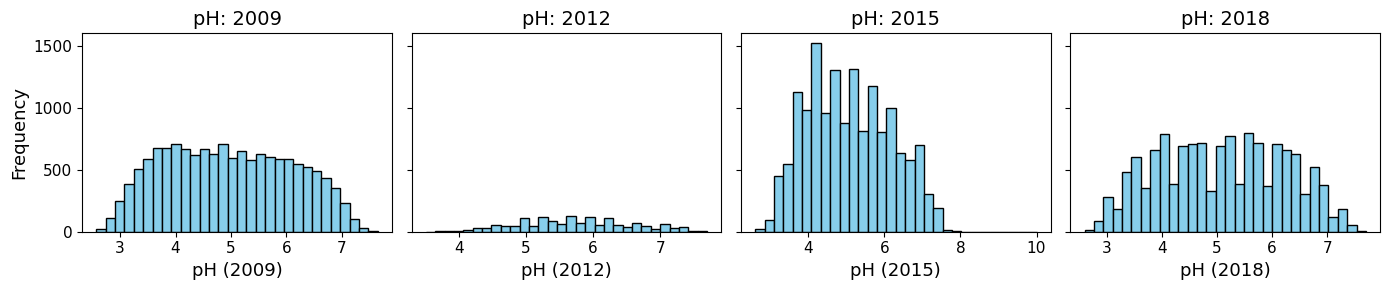

In [8]:
CaCO3_threshold = 5
for year in [2009, 2012, 2015, 2018]:
    # mask CaCO3 > threshold -> count
    print(f"Number of CaCO3_{year} > {CaCO3_threshold} vs <= {CaCO3_threshold}: {(df[f'CaCO3_{year}'] > CaCO3_threshold).sum()} / {(df[f'CaCO3_{year}'] <= CaCO3_threshold).sum()}")
    # create Calc as boolean, keeping NaN where CaCO3 is NaN, but dtype float for histogram compatibility
    vals = df[f'CaCO3_{year}']
    print("First 10 values:", vals.head(10).tolist())
    calc = vals.where(vals.isna(), vals > CaCO3_threshold)   # bool with NaN, but bool dtype
    print()
    print("First 10 values:", calc.head(10).tolist())
    df[f'Calc_{year}'] = calc.astype('float')  # convert True/False to 1.0/0.0, NaN stays NaN
    # CaCO3_c_log: log-transform CaCO3 values above threshold, else NaN
    df[f'CaCO3_c_{year}'] = vals.where(vals > CaCO3_threshold, np.nan)
    # Put pH_CaCl2 values where Calc is True into pH_c, and where Calc is False into pH
    df[f'pH_c_{year}'] = df[f'pH_CaCl2_{year}'].where(df[f'Calc_{year}'] == 1.0, np.nan)
    df[f'pH_{year}'] = df[f'pH_CaCl2_{year}'].where(df[f'Calc_{year}'] == 0.0, np.nan)

for var in ['pH_CaCl2', 'CaCO3', 'Calc', 'CaCO3_c_log', 'pH_c', 'pH']:
    hists(df, var)

SOC changes

In [9]:
def add_diff(df, var):
    df[f'd{var}_15_18'] = df[f'{var}_2018'] - df[f'{var}_2015']
    df[f'd{var}_{var}_15_18'] = df[f'd{var}_15_18'] / ((df[f'{var}_2018'] + df[f'{var}_2015'])/2)

for var in ['OC', 'N', 'P', 'K', 'CaCO3_c', 'CNr', 'CPr', 'CKr', 'Calc', 'pH_c', 'pH']:
    add_diff(df, var)

/tmp/ipykernel_2012970/4104712111.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'd{var}_{var}_15_18'] = df[f'd{var}_15_18'] / ((df[f'{var}_2018'] + df[f'{var}_2015'])/2)
/tmp/ipykernel_2012970/4104712111.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'd{var}_15_18'] = df[f'{var}_2018'] - df[f'{var}_2015']


In [10]:
df.to_pickle("2_preprocessed.pkl")